In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk 
import re 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib


In [2]:
# Download necessary nltk data
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/siddhant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Load the datasets
url = 'https://raw.githubusercontent.com/siddhantbhattarai/practice-datasets/main/SMSSpamCollection'
df = pd.read_csv(url, sep='\t', names=['label', 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Checking the missing values
df.isnull().sum()

label      0
message    0
dtype: int64

In [8]:
# Checking the duplicated values
df.duplicated().sum()

403

In [14]:
# Remove the duplicated datasets
cleaned_df = df.drop_duplicates()

In [15]:
# Checking the duplicated values
cleaned_df.duplicated().sum()

0

In [16]:
# Basics statistics of the datasets
cleaned_df.describe()

,label,message
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [17]:
# Count the spam vs ham messages
cleaned_df['label'].value_counts()

label
ham     4516
spam     653
Name: count, dtype: int64

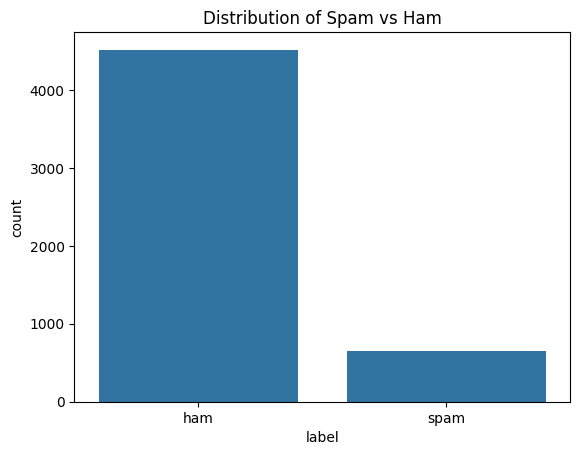

In [18]:
# Visualization: Distribution of spam vs ham
sns.countplot(x='label', data=cleaned_df)
plt.title('Distribution of Spam vs Ham')
plt.show()

/tmp/ipykernel_25505/2450959010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['message_length'] = cleaned_df['message'].apply(len)


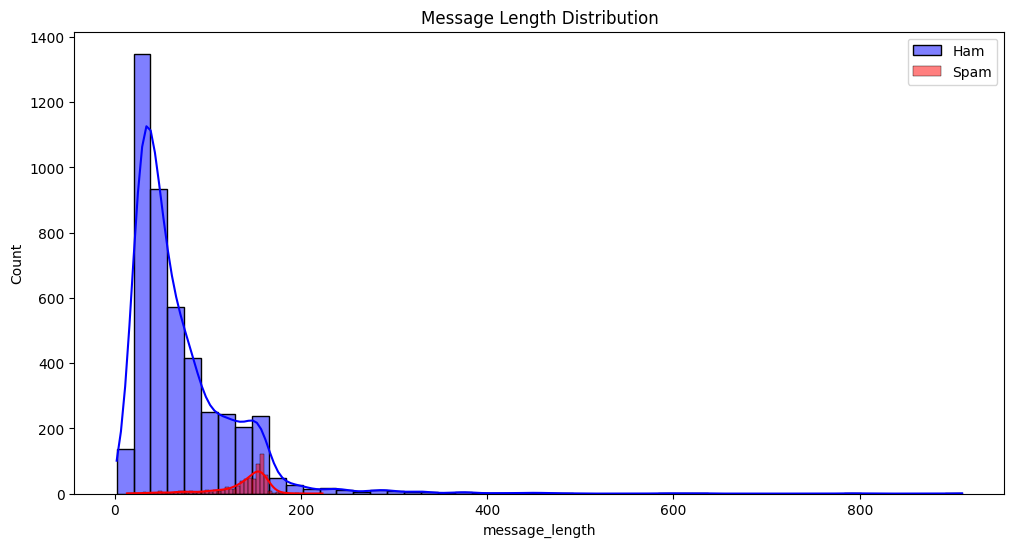

In [21]:
# Visualization: Message length analysis
cleaned_df['message_length'] = cleaned_df['message'].apply(len)
plt.figure(figsize=(12,6))
sns.histplot(cleaned_df[cleaned_df['label'] == 'ham']['message_length'], label='Ham', color='blue', bins=50, kde=True)
sns.histplot(cleaned_df[cleaned_df['label'] == 'spam']['message_length'], label='Spam', color='red', bins=50, kde=True)
plt.title('Message Length Distribution')
plt.legend()
plt.show()

In [22]:
# Visualization: word clouds for spam and ham messages
spam_words = ' '.join(cleaned_df[cleaned_df['label']== 'spam']['message'])
ham_words = ' '.join(cleaned_df[cleaned_df['label']== 'ham']['message'])

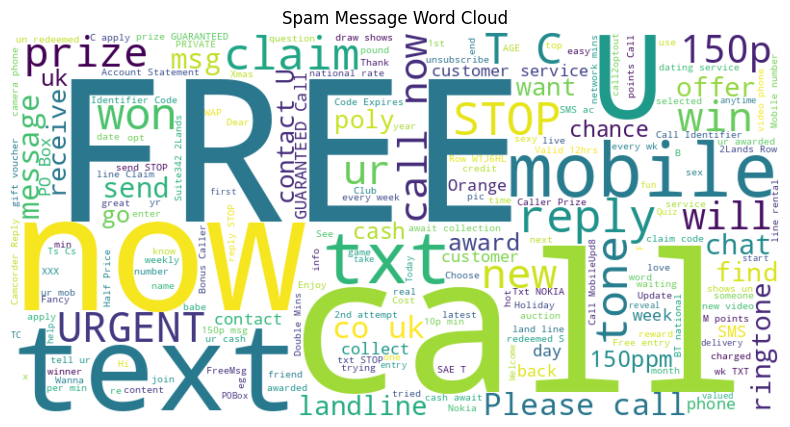

In [24]:
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)
plt.figure(figsize=(10,5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title("Spam Message Word Cloud")
plt.axis('off')
plt.show()

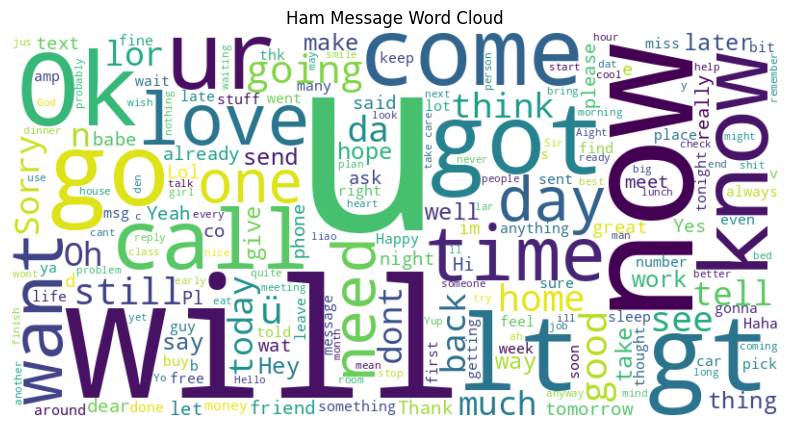

In [25]:
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title("Ham Message Word Cloud")
plt.axis('off')
plt.show()

In [26]:
# EDA: Tokenization and common word analysis
cleaned_df['tokens'] = cleaned_df['message'].apply(word_tokenize)
spam_tokens = [token for sublist in cleaned_df[cleaned_df['label'] == 'spam']['tokens'] for token in sublist]
ham_tokens = [token for sublist in cleaned_df[cleaned_df['label'] == 'ham']['tokens'] for token in sublist]

/tmp/ipykernel_25505/2954644893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['tokens'] = cleaned_df['message'].apply(word_tokenize)


In [27]:
spam_common_words = Counter(spam_tokens).most_common(20)
ham_common_words = Counter(ham_tokens).most_common(20)

In [28]:
spam_common_df = pd.DataFrame(spam_common_words, columns=['word', 'count'])
ham_common_df = pd.DataFrame(ham_common_words, columns=['word', 'count'])

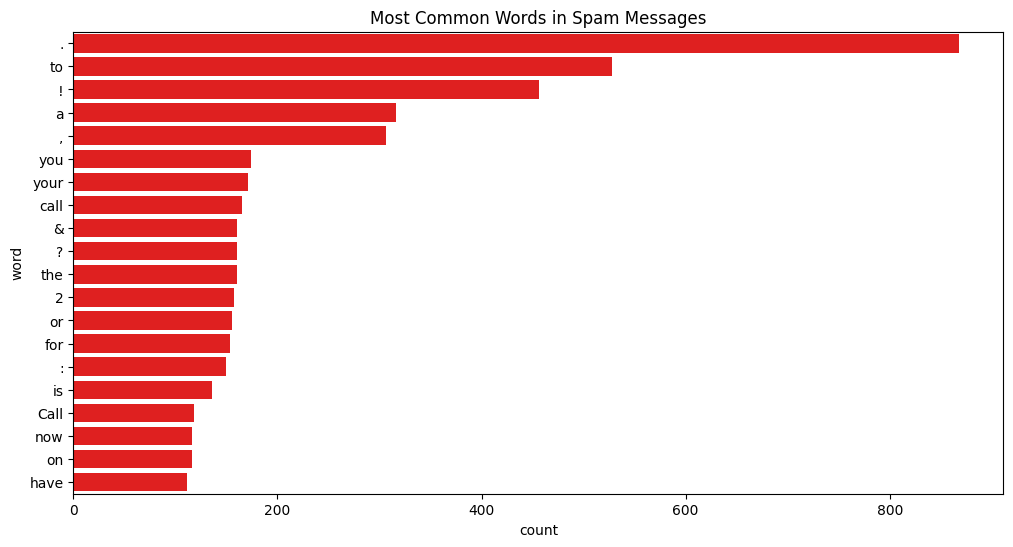

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=spam_common_df, color='red')
plt.title('Most Common Words in Spam Messages')
plt.show()

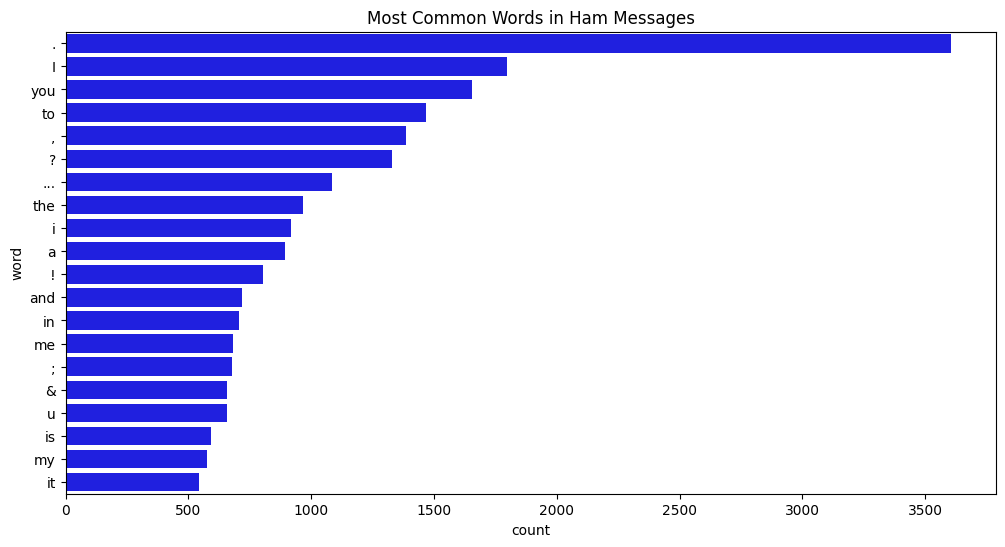

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=ham_common_df, color='blue')
plt.title('Most Common Words in Ham Messages')
plt.show()


In [32]:
# Data Cleaning 
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join(text.split())
    return text

cleaned_df['message'] = cleaned_df['message'].apply(clean_text)

/tmp/ipykernel_25505/1143839585.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['message'] = cleaned_df['message'].apply(clean_text)


In [34]:
# Data Preprocessing 
X = cleaned_df['message']
y = cleaned_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Feature Engineering: Convert the text data to TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [36]:
# Model Selection and Training 
# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [37]:
# Linear SVC (Support Vector Classifier)
svc_model = LinearSVC(dual=False)
svc_model.fit(X_train_tfidf, y_train)

LinearSVC(dual=False)

In [38]:
# Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [40]:
# Model Evaluation
nb_predictions = nb_model.predict(X_test_tfidf)
svc_predictions = svc_model.predict(X_test_tfidf)
rf_predictions = rf_model.predict(X_test_tfidf)

nb_accuracy = accuracy_score(y_test, nb_predictions)
svc_accuracy = accuracy_score(y_test, svc_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print(f'Multinomial Naive Bayes Accuracy: {nb_accuracy*100:.2f}%')
print(f'Linear SVC Accuracy: {svc_accuracy*100:.2f}%')
print(f'Random Forest Accuracy: {rf_accuracy*100:.2f}%')

Multinomial Naive Bayes Accuracy: 95.55%
Linear SVC Accuracy: 98.26%
Random Forest Accuracy: 96.71%
